Project Title: Energy Forecasting using ML Models

This notebook contains the following Topics

1. Project Description, Data Sources and other references
2. Importing libraries
3. Interpreting  Dataset
4. Exploratory Data Analysis
5. Feature Engineering
6. Model Creation and Evaluation (Multiple Linear Regression, Random Forest and XG Boost)

The EnergyDemand_dataset.xlsx contains hourly Real-Time (RT)  energy demand and weather data for the ISO New England Control Area (ISO NE CA). ISO New England Control area consist of MA, VT, CT, NH , ME , RI states.  <br>The dataset is sourced from https://www.iso-ne.com/isoexpress/web/reports/load-and-demand/-/tree/zone-info and spans a four-year period (2016-2019) containing 35064 records. The primary objective is to utilize this real dataset to  forecast energy consumption  and evaluating the machine model performance. <br><br>

Key Columns:<br>
1.Date: Represents the calendar date of the provided data.
  
2.Hr_End:Indicates the hour of the observation, following the hour-ending and 24-hour convention.

3.RT_Demand: Represents Real-Time Demand in megawatts (MW). It corresponds to Non-PTF Demand for wholesale market settlement and is derived from revenue quality metering. It is defined as the sum of non-dispatchable load assets, station service load assets, and unmetered load assets.

4.Dry_Bulb_Temp: Indicates the dry-bulb temperature in Fahrenheit (°F) for the weather station corresponding to the load zone or Trading Hub. The temperature is categorized into summer (June-September) and winter (October-May) periods.

5.Dew_Point_Temp:Represents the dewpoint temperature in Fahrenheit (°F) for the weather station corresponding to the load zone or Trading Hub. Similar to dry-bulb temperature, it is categorized into summer (June-September) and winter (October-May) periods.

The dataset is comprehensive, covering various aspects of Real-Time demand and weather conditions, and will be utilized for predicting energy forecasts based on the provided information.

Ref:This implementation is motivated from "Electric load forecasting with recency effect: A big data approach" Research Paper


IMPORTING LIBRARIES

In [ ]:
import pandas as pd
from patsy import dmatrices
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/Users/Saurabh/Desktop/EnergyForecast_dataset.xlsx'
dataset = pd.read_excel(file_path)

In [ ]:
# Displaying information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            35064 non-null  datetime64[ns]
 1   Hr_End          35064 non-null  int64         
 2   RT_Demand       35064 non-null  float64       
 3   Dry_Bulb_Temp   35064 non-null  int64         
 4   Dew_Point_Temp  35064 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 1.3 MB


In [ ]:
# Check for missing values in the dataset
dataset.isnull().sum()

Date              0
Hr_End            0
RT_Demand         0
Dry_Bulb_Temp     0
Dew_Point_Temp    0
dtype: int64

In [ ]:
# Displaying descriptive statistics
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Hr_End,35064.0,12.500000,6.922285,1.000,6.750,12.5000,18.25000,24.000
RT_Demand,35064.0,13703.547185,2690.887721,8201.861,11801.473,13533.7825,15231.11325,25612.175
Dry_Bulb_Temp,35064.0,50.916210,18.621856,-11.000,36.000,51.0000,67.00000,94.000
Dew_Point_Temp,35064.0,39.231291,19.534916,-25.000,25.000,41.0000,55.00000,75.000


Exploratory Data Analysis


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Convert 'Date' to datetime format
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d-%b-%y')

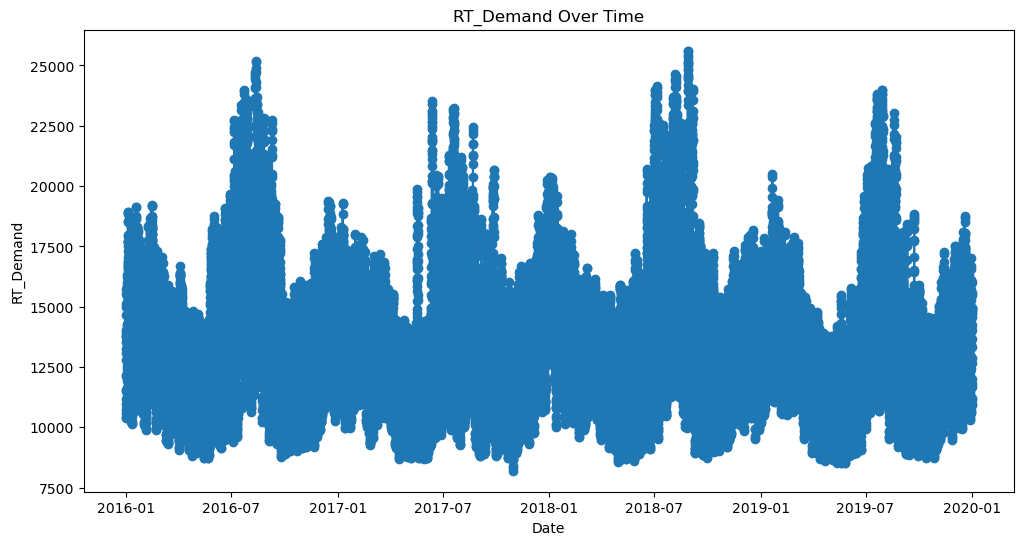

In [ ]:
#Visualize time series data for RT_Demand
plt.figure(figsize=(12, 6))
plt.plot(dataset['Date'], dataset['RT_Demand'], marker='o')
plt.title('RT_Demand Over Time')
plt.xlabel('Date')
plt.ylabel('RT_Demand')
plt.show()

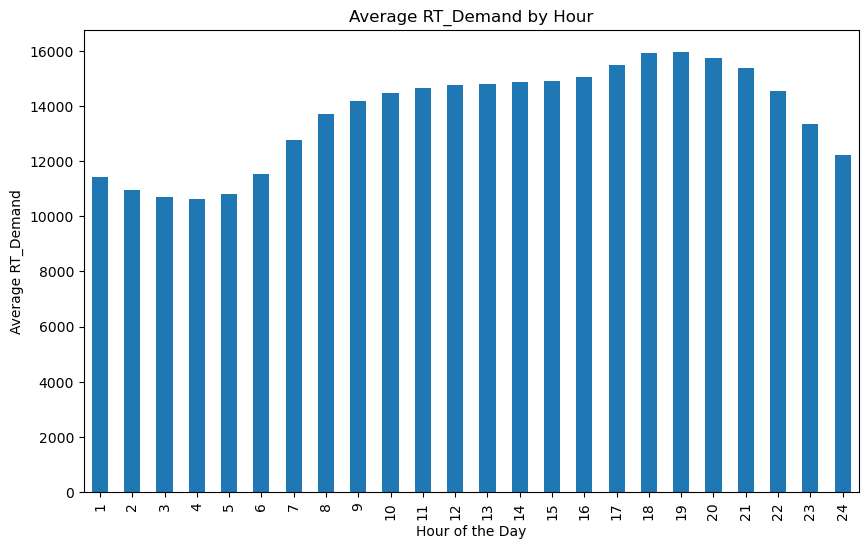

In [ ]:
# Group by hour and visualize demand patterns
hourly_demand = dataset.groupby('Hr_End')['RT_Demand'].mean()

plt.figure(figsize=(10, 6))
hourly_demand.plot(kind='bar')
plt.title('Average RT_Demand by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average RT_Demand')
plt.show()

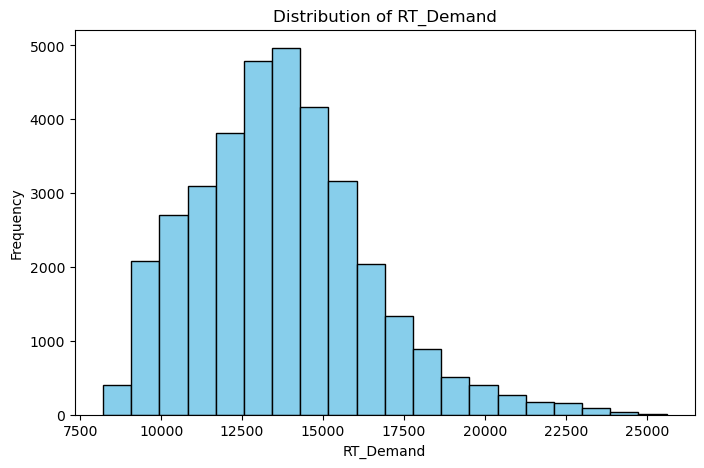

In [ ]:
# Histogram and Distribution
plt.figure(figsize=(8, 5))
plt.hist(dataset['RT_Demand'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of RT_Demand')
plt.xlabel('RT_Demand')
plt.ylabel('Frequency')
plt.show()

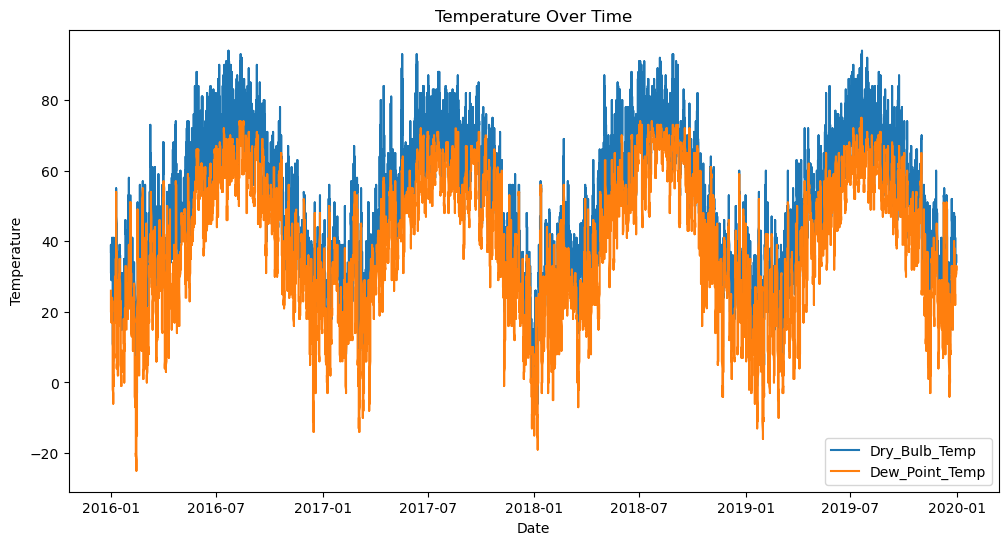

In [ ]:
# Plot temperature over time
plt.figure(figsize=(12, 6))
plt.plot(dataset['Date'], dataset['Dry_Bulb_Temp'], label='Dry_Bulb_Temp')
plt.plot(dataset['Date'], dataset['Dew_Point_Temp'], label='Dew_Point_Temp')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

FEATURE ENGINEERING

<AxesSubplot:>

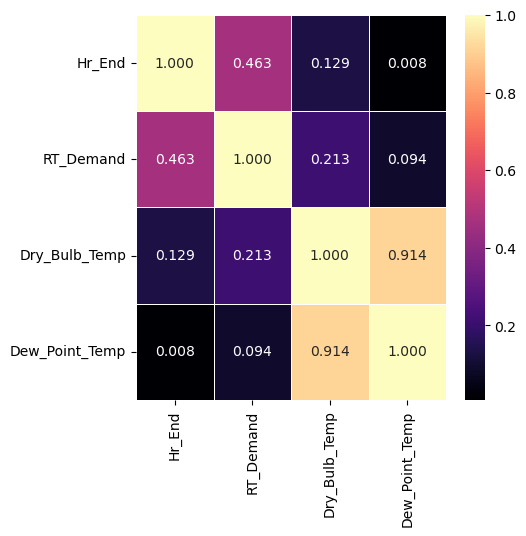

In [ ]:
# Checking the correlation between columns
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the figure size for the heatmap
plt.rcParams['figure.figsize']  = (5,5)
matrix = dataset.corr()

# Creating a heatmap to visualize the correlation matrix
sns.heatmap(matrix, fmt = ".3f", linewidths = 0.7, cmap = "magma" ,annot = True)

Features exhibiting high correlation are often linearly dependent and exert a similar influence on the dependent variable.<br>
(Dew_Point_Temp) and (Dry_Bulb_Temp) are highly correlated = 0.914<br><br>
RT_Demand has high correlation with Dry_Bulb_Temp as compared to Dew_Point_Temp hence, we can drop Dew_Point_Temp.

Text(0, 0.5, 'Energy Demand')

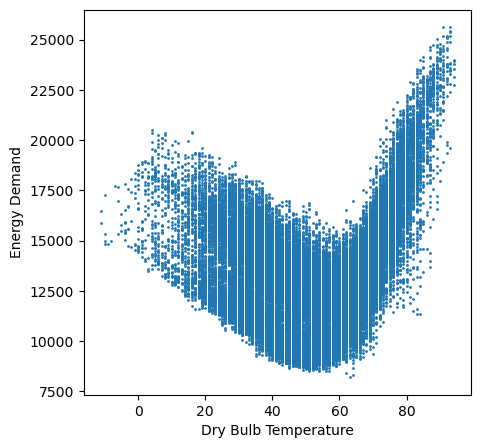

In [ ]:
# Scatter plot RT_Demand Vs Temperature showing polynomial relationship
a=dataset.plot.scatter(x = 'Dry_Bulb_Temp', y = 'RT_Demand', s = 1)
a.set_xlabel("Dry Bulb Temperature")
a.set_ylabel("Energy Demand")

This shows there exist polynomial relationship between Temperature and Energy Demand. Hence, 2nd and 3rd ordered polynomials of the temperature can be applied to model.

CREATE NEW FEATURES

In [ ]:
# Create a new column 't2' by squaring the values in the 'Dry_Bulb_Temp' column
dataset['t2'] = dataset['Dry_Bulb_Temp']**2

# Create another new column 't3' by cubing the values in the 'Dry_Bulb_Temp' column
dataset['t3'] = dataset['Dry_Bulb_Temp']**3

In [ ]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Extract the day of the week and add a new 'weekday' column
dataset['weekday'] = dataset['Date'].dt.dayofweek

# Extract the month and add a new 'month' column
dataset['month'] = dataset['Date'].dt.month

# Extract the year and add a new 'year' column
dataset['year'] = dataset['Date'].dt.year

# Create a 'Trend' column representing the index incremented by 1
dataset['Trend'] = dataset.index + 1

In [ ]:
# Displaying the first few rows of the dataset
dataset = dataset.drop('Dew_Point_Temp', axis=1)
dataset.head()

,Date,Hr_End,RT_Demand,Dry_Bulb_Temp,t2,t3,weekday,month,year,Trend
0,2016-01-01,1,11513.897,37,1369,50653,4,1,2016,1
1,2016-01-01,2,10964.352,37,1369,50653,4,1,2016,2
2,2016-01-01,3,10574.445,37,1369,50653,4,1,2016,3
3,2016-01-01,4,10385.898,36,1296,46656,4,1,2016,4
4,2016-01-01,5,10421.392,35,1225,42875,4,1,2016,5


In [ ]:
# Splitting the dataset into training and test sets based on the 'year' column.

# Selecting the training set containing data for the years 2016, 2017, and 2018
Training = dataset[dataset['year'].isin([2016, 2017, 2018])]

# Selecting the test set containing data for the year 2019
Test = dataset[dataset['year'].isin([2019])]

CREATING MODELS

In [ ]:
from sklearn.linear_model import LinearRegression
from  xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

This project uses the following equations  :<br><br>
y<sub>t</sub> = load forecast for time (hour) t <br>
βi = coefficients estimated using the ordinary least squares method <br>
M<sub>t</sub>, W<sub>t</sub> and H<sub>t</sub> are the month-of-the-year, day-of-the-week, and hour-of-the-day classification variables corresponding to time t <br>
T<sub>t</sub> = temperature at time t <br>

y<sub>t</sub> = β0 + β1 Trend<sub>t</sub> +β2M<sub>t</sub> + β3W<sub>t</sub> + β4H<sub>t</sub> + β5 W<sub>t</sub> H<sub>t</sub> + f(T <sub>t</sub>) <br>

f(T <sub>t</sub>) =  β6 T<sub>t</sub> + β7 T<sup>2</sup><sub>t<sub> + β8 T<sup>3</sup><sub>t<sub> + β9 T<sub>t<sub> M<sup>t</sup> + β10 T<sup>2</sup><sub>t<sub> M<sup>t</sup> + β11 T<sup>3</sup><sub>t<sub> M<sup>t</sup> + β12 T<sub>t<sub> H<sup>t</sup> +β13 T<sup>2</sup><sub>t<sub> H<sup>t</sup> + β14 T<sup>3</sup><sub>t<sub> H<sup>t</sup>



In [ ]:
y_train, X_train= dmatrices('RT_Demand ~ Trend +C(weekday)+ C(month)+ C(Hr_End)+C(weekday)*C(Hr_End)+ Dry_Bulb_Temp + t2 + t3 + C(Hr_End)*Dry_Bulb_Temp+C(Hr_End)*t2 + C(Hr_End)*t3 + C(month)*Dry_Bulb_Temp +C(month)*t2 + C(month)*t3', Training,return_type="dataframe")
y_test, X_test= dmatrices  ('RT_Demand ~ Trend +C(weekday)+ C(month)+ C(Hr_End)+C(weekday)*C(Hr_End)+ Dry_Bulb_Temp + t2 + t3 + C(Hr_End)*Dry_Bulb_Temp+C(Hr_End)*t2 + C(Hr_End)*t3 + C(month)*Dry_Bulb_Temp +C(month)*t2 + C(month)*t3', Test, return_type="dataframe")

MULTIPLE LINEAR REGRESSION MODEL

In [ ]:
def regression(X_train, y_train, X_test):
    # Initialize and train the linear regression model
    model=LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred1=model.predict(X_test)
    return y_pred1

# Call the polynomial_regression function
y_pred1=regression(X_train, y_train, X_test)

# Calculate MAPE (Mean Absolute Percentage Error)
mape=round(((abs(y_pred1-y_test.values)/y_test)).mean()*100,2)

In [ ]:
# Print the MAPE
print(f'MAPE for Multiple linear Regression: {mape}', '%')

MAPE for Multiple linear Regression: RT_Demand    3.75
dtype: float64 %


XGBoost

In [ ]:
def xgboost_regression(X_train, y_train, X_test):
    # Initialize XGBoost Regressor with 500 estimators
    reg = XGBRegressor(n_estimators=500)

    # Fit the model on the training data
    reg.fit(X_train.values, y_train.values)

    # Make predictions on the test data
    y_pred2=reg.predict(X_test.values)
    return y_pred2

# Call the xgboost_regression function
y_pred2=xgboost_regression(X_train, y_train, X_test)

# Calculate MAPE (Mean Absolute Percentage Error)
XG_mape=round(((abs(y_pred2-y_test.values.reshape(y_pred2.shape))/y_test.values)).mean()*100,2)

In [ ]:
# Print the MAPE for XGBoost
print(f'MAPE for XGBoost: {XG_mape}','%')

MAPE for XGBoost: 5.39 %


RANDOM FOREST REGRESSION

In [ ]:
def predict_random_forest(X_train, y_train, X_test):
    # Initialize a Random Forest Regressor with specified parameters
    random_forest_model = RF_Model = RandomForestRegressor(n_estimators=100, max_features=1, oob_score=True)

    # Fit the model to the training data
    random_forest_model.fit(X_train.values, y_train.values)

    # Make predictions on the test set
    y_pred3=random_forest_model.predict(X_test.values)
    return y_pred3

# Call the predict_random_forest function
y_pred3=predict_random_forest(X_train, y_train, X_test)

# Calculate MAPE (Mean Absolute Percentage Error)
random_forest_mape=round(((abs(y_pred3-y_test.values.reshape(y_pred3.shape))/y_test.values)).mean()*100, 2)

/var/folders/r9/2g017y_x3sj2d9_5923sl2rc0000gn/T/ipykernel_47055/1771362730.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_model.fit(X_train.values, y_train.values)


In [ ]:
print(f'MAPE for Random Forest: {random_forest_mape}','%')

MAPE for Random Forest: 4.83 %


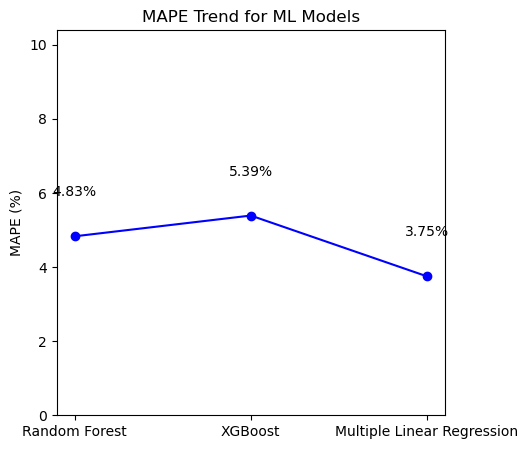

In [ ]:
import matplotlib.pyplot as plt

# Sample MAPE values for three ML models
random_forest_mape = 4.83
XG_mape = 5.39
mape = 3.75

# Model names
model_names = ['Random Forest', 'XGBoost', 'Multiple Linear Regression']

# Plotting the line chart
plt.plot(model_names, [random_forest_mape, XG_mape, mape], marker='o', linestyle='-', color='blue')
plt.ylabel('MAPE (%)')
plt.title('MAPE Trend for ML Models')
plt.ylim(0, max([random_forest_mape, XG_mape, mape]) + 5)  # Adjust the y-axis limit if needed

# Display the values next to the data points
for i, value in enumerate([random_forest_mape, XG_mape, mape]):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom')

# Show the plot
plt.show()



Conclusion : Mean Absolute Percentage Error of Multiple Linear Regression is lowest (3.75%) compared to Random Forest(4.88%) and XGBoost(5.39%) model performance.
Hypertuning the parameters of Random Forest and XGBoost model may improve performance of the model.